<a href="https://colab.research.google.com/github/website31/AI-project-team-J/blob/main/Sketch_to_Shade_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
!{sys.executable} -m pip install inference-sdk opencv-python numpy matplotlib torch torchvision

In [ ]:
from google.colab import files

print("Please upload the image for the window:")
uploaded_window = files.upload()

window_image_path = list(uploaded_window.keys())[0]
print(f'Uploaded window image: {window_image_path}')

print("\nPlease upload the image for the shading device:")
uploaded_shading = files.upload()

shading_image_path = list(uploaded_shading.keys())[0]
print(f'Uploaded shading device image: {shading_image_path}')

Please upload the image for the window:


Saving image (1).jfif to image (1) (7).jfif
Uploaded window image: image (1) (7).jfif

Please upload the image for the shading device:


Saving w 1.png to w 1 (7).png
Uploaded shading device image: w 1 (7).png


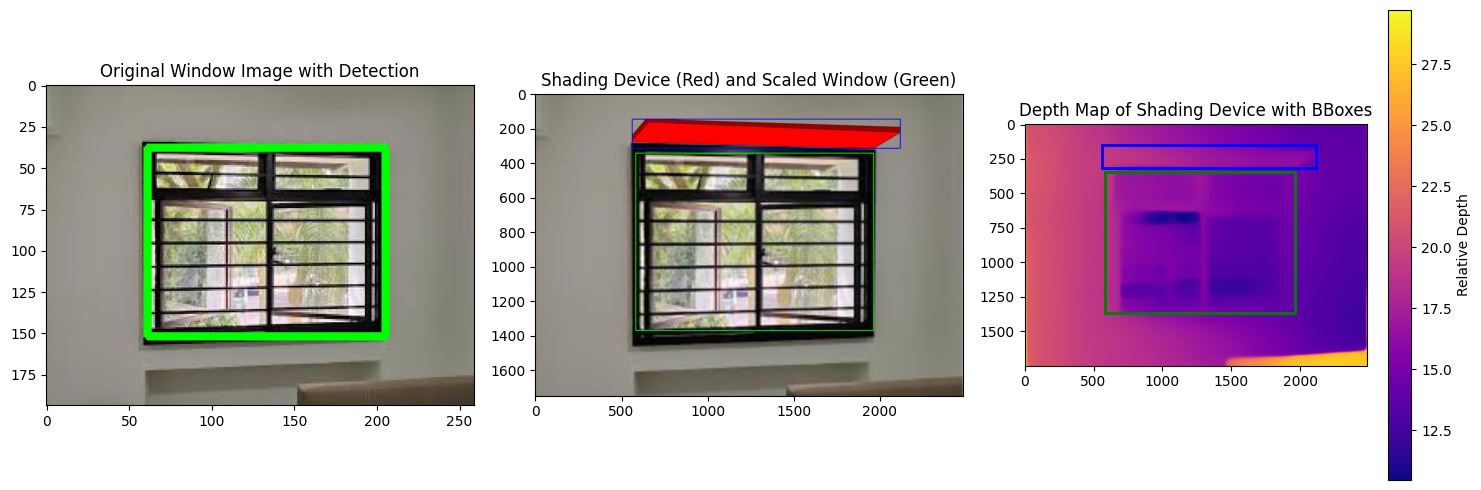


Results saved to: result_detection.jpg

EXPORT TO RHINO:
width_ratio       = 10.791666666666666
proportional_depth= 13.336994056161878
horizontal_offset = 3.486111111111111
vertical_offset   = 0.9385964912280702
Processing window image: image (1) (7).jfif
Processing shading device image: w 1 (7).png
Window image dimensions: 259x194
Shading device image dimensions: 2481x1749
Window detected in window image (used for proportions): (61, 38, 144, 114)
Shading device detected: (563, 145, 1554, 169)


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Mean window depth:  12.718
Mean shading depth: 16.962


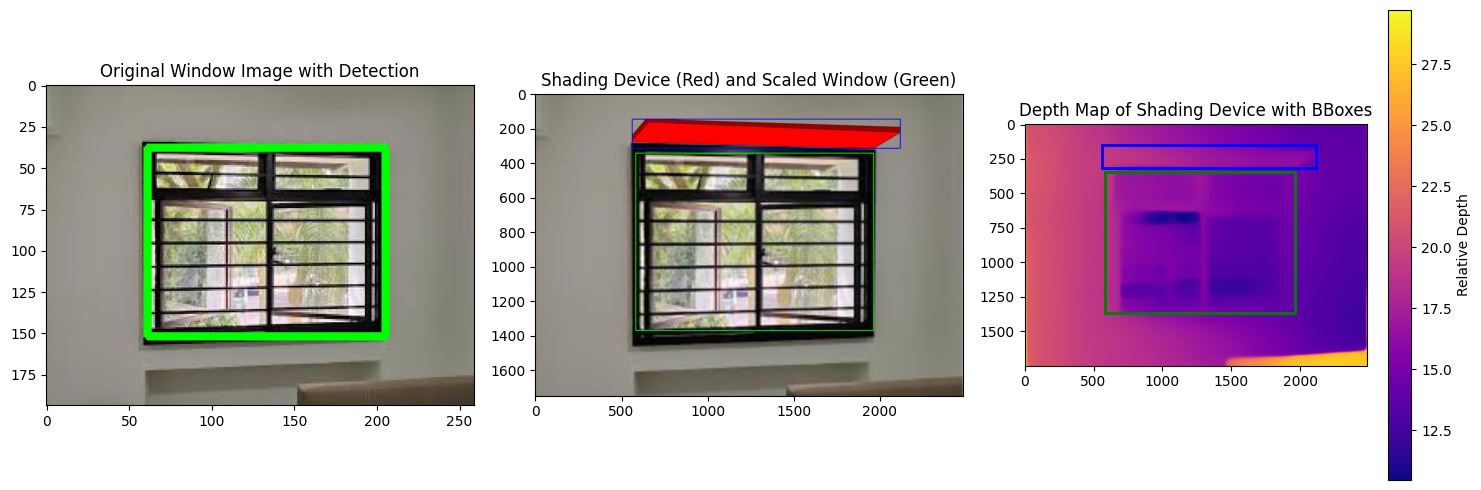


Results saved to: result_detection.jpg

EXPORT TO RHINO:
width_ratio       = 10.791666666666666
proportional_depth= 13.336994056161878
horizontal_offset = 3.486111111111111
vertical_offset   = 0.9385964912280702


In [ ]:
import cv2
import numpy as np
import torch
from inference_sdk import InferenceHTTPClient
from matplotlib import pyplot as plt

# --- MiDaS Model Loader and Depth Functions ---
def get_midas_model(model_type='DPT_Large'):
    midas = torch.hub.load('intel-isl/MiDaS', model_type)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    midas.to(device)
    midas.eval()
    transforms = torch.hub.load('intel-isl/MiDaS', 'transforms')
    transform = transforms.dpt_transform if 'DPT' in model_type else transforms.small_transform
    return midas, transform, device

def estimate_depth(input_image_path, midas, transform, device):
    img = cv2.imread(input_image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    input_batch = transform(img_rgb).to(device)
    with torch.no_grad():
        prediction = midas(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()
    depth_map = prediction.cpu().numpy()
    return depth_map, img

def get_bbox_mean_depth(depth_map, bbox):
    x, y, w, h = bbox
    region = depth_map[y:y+h, x:x+w]
    return float(np.mean(region))


def detect_window_with_roboflow(image_path, api_key):
    CLIENT = InferenceHTTPClient(
        api_url="https://serverless.roboflow.com",
        api_key=api_key
    )
    result = CLIENT.infer(image_path, model_id="window-detection-tpx4d/3")
    if not result["predictions"]:
        return None, None
    best_window = max(result["predictions"], key=lambda d: d['confidence'])
    x = int(best_window['x'] - best_window['width'] / 2)
    y = int(best_window['y'] - best_window['height'] / 2)
    w = int(best_window['width'])
    h = int(best_window['height'])
    bbox = (x, y, w, h)
    return bbox, best_window

def detect_shading_device(shading_image_path, color_lower, color_upper):
    img = cv2.imread(shading_image_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, color_lower, color_upper)
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        shading_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(shading_contour)
        return (x, y, w, h), shading_contour, mask
    return None, None, mask


def calculate_proportions(window_bbox, shading_bbox, mean_window_depth, mean_shading_depth):
    if window_bbox is None or shading_bbox is None:
        return None
    win_x, win_y, win_w, win_h = window_bbox
    shd_x, shd_y, shd_w, shd_h = shading_bbox
    proportions = {
        'width_ratio': shd_w / win_w,
        'height_ratio': shd_h / win_h,
        'horizontal_offset': (shd_x - win_x) / win_w,
        'vertical_offset': (shd_y - win_y) / win_h,
        'center_x_diff': ((shd_x + shd_w/2) - (win_x + win_w/2)) / win_w,
        'center_y_diff': ((shd_y + shd_h/2) - (win_y + win_h/2)) / win_h,
        'window_width_px': win_w,
        'window_height_px': win_h,
        'shading_width_px': shd_w,
        'shading_height_px': shd_h,
        'mean_window_depth': mean_window_depth,
        'mean_shading_depth': mean_shading_depth,
        'proportional_depth': (mean_shading_depth / mean_window_depth)*10 if mean_window_depth!=0 else None
    }
    return proportions


def process_window_image(window_image_path, shading_image_path, shading_color_lower, shading_color_upper, api_key):
    print(f"Processing window image: {window_image_path}")
    print(f"Processing shading device image: {shading_image_path}")
    print("="*60)

    # Load images to get dimensions
    img_window_raw = cv2.imread(window_image_path)
    img_shading_raw = cv2.imread(shading_image_path)

    if img_window_raw is None or img_shading_raw is None:
        print("Error: Could not load one or both images.")
        return None, None

    win_h_raw, win_w_raw, _ = img_window_raw.shape
    shd_h_raw, shd_w_raw, _ = img_shading_raw.shape

    print(f"Window image dimensions: {win_w_raw}x{win_h_raw}")
    print(f"Shading device image dimensions: {shd_w_raw}x{shd_h_raw}")

    # Step 1: Detect window and shading bounding boxes
    window_bbox, _ = detect_window_with_roboflow(window_image_path, api_key) # Primary window detection
    if window_bbox is None:
        print("ERROR: Could not detect window in the window image!")
        return None, None
    print(f"Window detected in window image (used for proportions): {window_bbox}")

    shading_bbox, shading_contour, mask = detect_shading_device(
        shading_image_path, shading_color_lower, shading_color_upper)
    if shading_bbox is None:
        print("ERROR: Could not detect shading device!")
        return None, None
    print(f"Shading device detected: {shading_bbox}")

    # Step 2: MiDaS depth map & mean depth for boxes
    midas, transform, device = get_midas_model('DPT_Large')
    depth_map_window, img_window = estimate_depth(window_image_path, midas, transform, device)
    depth_map_shading, img_shading = estimate_depth(shading_image_path, midas, transform, device)

    mean_window_depth = get_bbox_mean_depth(depth_map_window, window_bbox) # Use primary window bbox for depth
    mean_shading_depth = get_bbox_mean_depth(depth_map_shading, shading_bbox)
    print(f"Mean window depth:  {mean_window_depth:.3f}")
    print(f"Mean shading depth: {mean_shading_depth:.3f}")

    # Step 3: Calculate all proportions (including proportional_depth)
    proportions = calculate_proportions(window_bbox, shading_bbox, mean_window_depth, mean_shading_depth)

    # Visualization
    plt.figure(figsize=(15, 5))

    # Plot 1: Original Window Image with Detected Window
    plt.subplot(1, 3, 1)
    img_window_display = cv2.imread(window_image_path)
    cv2.rectangle(img_window_display, (window_bbox[0], window_bbox[1]),
                  (window_bbox[0] + window_bbox[2], window_bbox[1] + window_bbox[3]),
                  (0, 255, 0), 3) # Green for window
    plt.imshow(cv2.cvtColor(img_window_display, cv2.COLOR_BGR2RGB))
    plt.title('Original Window Image with Detection')

    # Plot 2: Shading Device Image with Both Detections (Window BBox Scaled)
    plt.subplot(1, 3, 2)
    img_for_display = cv2.imread(shading_image_path) # Load the shading image for display

    # Calculate scaling factors
    scale_x = shd_w_raw / win_w_raw
    scale_y = shd_h_raw / win_h_raw

    # Scale window_bbox for display on the shading image
    scaled_window_bbox = (
        int(window_bbox[0] * scale_x),
        int(window_bbox[1] * scale_y),
        int(window_bbox[2] * scale_x),
        int(window_bbox[3] * scale_y)
    )

    cv2.rectangle(img_for_display, (shading_bbox[0], shading_bbox[1]),
                  (shading_bbox[0] + shading_bbox[2], shading_bbox[1] + shading_bbox[3]),
                  (255, 0, 0), 3) # Red for shading
    cv2.rectangle(img_for_display, (scaled_window_bbox[0], scaled_window_bbox[1]),
                  (scaled_window_bbox[0] + scaled_window_bbox[2], scaled_window_bbox[1] + scaled_window_bbox[3]),
                  (0, 255, 0), 3) # Green for scaled window
    plt.imshow(cv2.cvtColor(img_for_display, cv2.COLOR_BGR2RGB))
    plt.title('Shading Device (Red) and Scaled Window (Green)')

    # Plot 3: Depth Map of Shading Device with BBoxes
    plt.subplot(1, 3, 3)
    plt.imshow(depth_map_shading, cmap='plasma') # Use shading's depth map for visualization
    x_shd, y_shd, w_shd, h_shd = shading_bbox
    plt.gca().add_patch(plt.Rectangle((x_shd, y_shd), w_shd, h_shd, fill=False, edgecolor='blue', linewidth=2))
    x_win_scaled, y_win_scaled, w_win_scaled, h_win_scaled = scaled_window_bbox
    plt.gca().add_patch(plt.Rectangle((x_win_scaled, y_win_scaled), w_win_scaled, h_win_scaled, fill=False, edgecolor='green', linewidth=2))
    plt.title('Depth Map of Shading Device with BBoxes')
    plt.colorbar(label='Relative Depth')
    plt.tight_layout()
    plt.show()

    return proportions, img_for_display # Return the shading image with detection for saving

# --- Example Usage ---
if __name__ == "__main__":
    # Ensure that `window_image_path` and `shading_image_path` are defined in a previous cell via `files.upload()`
    global window_image_path, shading_image_path # Declare as global if running in a script-like manner in Colab

    api_key = "sSzyjm4yydTThf4EavAt"
    color_lower = np.array([0, 100, 100])
    color_upper = np.array([10, 255, 255])
    proportions, result_img = process_window_image(
        window_image_path, shading_image_path, color_lower, color_upper, api_key)
    if proportions is not None:
        cv2.imwrite("result_detection.jpg", result_img)
        print("\nResults saved to: result_detection.jpg")
        print("\n" + "="*60)
        print("EXPORT TO RHINO:")
        print(f"width_ratio       = {proportions['width_ratio']}")
        print(f"proportional_depth= {proportions['proportional_depth']}")
        print(f"horizontal_offset = {proportions['horizontal_offset']}")
        print(f"vertical_offset   = {proportions['vertical_offset']}")

To upload an image from your computer, run the following cell. A file selection dialog will appear where you can choose your image file.

Once you have uploaded your image, replace `"/content/curve 2.png"` with the name of your uploaded file in the `image_path` variable and rerun the cell where `process_window_image` is called.

In [ ]:
if proportions is not None:
    window_height = proportions['window_height_px']
    window_width = proportions['window_width_px']

    if window_width != 0:
        height_by_width_ratio = window_height / window_width
        print(f"Window Height by Window Width: {height_by_width_ratio:.3f}")
    else:
        print("Window width is zero, cannot calculate ratio.")
else:
    print("Proportions not available.")

Window Height by Window Width: 0.792


### Export Values for Rhino Model

In [ ]:
print("--- RHINO EXPORT DATA ---")

if proportions is not None:
    print(f"proportional_depth = {proportions.get('proportional_depth', 'N/A')}")
    print(f"width_ratio = {proportions.get('width_ratio', 'N/A')}")
    print(f"horizontal_offset = {proportions.get('horizontal_offset', 'N/A')}")
    print(f"vertical_offset = {proportions.get('vertical_offset', 'N/A')}")

    window_height_px = proportions.get('window_height_px')
    window_width_px = proportions.get('window_width_px')
    if window_width_px is not None and window_width_px != 0:
        window_height_by_width_ratio = window_height_px / window_width_px
        print(f"window_height_by_width_ratio = {window_height_by_width_ratio}")
    else:
        print("window_height_by_width_ratio = N/A (Window width is zero or not available)")
else:
    print("Proportions dictionary is not available.")

# Ensure selected_direction is available
if 'selected_direction' in globals():
    print(f"selected_direction = '{selected_direction}'")
else:
    print("selected_direction = N/A (Direction not selected)")

print("-------------------------")
print("Copy the above lines into your Rhino Python script or Grasshopper Python component.")

--- RHINO EXPORT DATA ---
proportional_depth = 13.336994056161878
width_ratio = 10.791666666666666
horizontal_offset = 3.486111111111111
vertical_offset = 0.9385964912280702
window_height_by_width_ratio = 0.7916666666666666
selected_direction = N/A (Direction not selected)
-------------------------
Copy the above lines into your Rhino Python script or Grasshopper Python component.


In [ ]:
import ipywidgets as widgets
from IPython.display import display

In [ ]:
direction_selector = widgets.Dropdown(
    options=['North', 'South', 'East', 'West'],
    value='North',
    description='Select Direction:',
    disabled=False,
)

In [ ]:
display(direction_selector)

Dropdown(description='Select Direction:', options=('North', 'South', 'East', 'West'), value='North')

In [ ]:
selected_direction = direction_selector.value
print(f"You selected: {selected_direction}")

# Consolidating output as requested by the user
print("\n--- Combined Results ---")
if 'proportions' in globals() and proportions is not None:
    print(f"Proportional Depth        : {proportions['proportional_depth']}")
else:
    print("Proportional Depth        : Not available (proportions not calculated)")

if 'window_height' in globals() and 'window_width' in globals() and window_width != 0:
    height_by_width_ratio = window_height / window_width
    print(f"Window Height by Width    : {height_by_width_ratio:.3f}")
elif 'proportions' in globals() and proportions is not None and proportions['window_width_px'] != 0:
    # Fallback if window_height/width were not set as global for some reason
    height_by_width_ratio = proportions['window_height_px'] / proportions['window_width_px']
    print(f"Window Height by Width    : {height_by_width_ratio:.3f}")
else:
    print("Window Height by Width    : Not available (window dimensions not calculated or width is zero)")

print(f"Selected Direction        : {selected_direction}")

You selected: North

--- Combined Results ---
Proportional Depth        : 13.336994056161878
Window Height by Width    : 0.792
Selected Direction        : North


Adding Grasshopper into Collab

In [ ]:
!pip install pyngrok


In [ ]:
!kill -9 $(lsof -t -i:5000)

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


In [ ]:
import ghhops_server
from flask import Flask

app = Flask(__name__)
hops = ghhops_server.Hops(app)

@hops.component(
    "/shading_eui_analysis",
    name="Shading EUI Analysis",
    inputs=[],  # No inputs
    outputs=[
        ghhops_server.HopsNumber("ProportionalDepth", "Proportional Depth"),
        ghhops_server.HopsNumber("HeightByWidth", "Window Height by Width"),
        ghhops_server.HopsString("Direction", "Orientation"),
    ]
)
def eui_analysis():
    proportional_depth = None
    height_by_width_ratio = None
    direction = None

    if 'proportions' in globals() and proportions is not None:
        proportional_depth = proportions['proportional_depth']
        if proportions.get('window_width_px', 0) != 0:
            height_by_width_ratio = proportions['window_height_px'] / proportions['window_width_px']

    if 'selected_direction' in globals():
        direction = selected_direction

    return proportional_depth, height_by_width_ratio, direction

# --- Code for printing combined results and ngrok setup ---
print("\n--- Combined Results ---")
if 'proportions' in globals() and proportions is not None:
    print(f"Proportional Depth        : {proportions['proportional_depth']}")
else:
    print("Proportional Depth        : Not available (proportions not calculated)")

if 'window_height' in globals() and 'window_width' in globals() and window_width != 0:
    height_by_width_ratio = window_height / window_width
    print(f"Window Height by Width    : {height_by_width_ratio:.3f}")
elif 'proportions' in globals() and proportions is not None and proportions.get('window_width_px', 0) != 0:
    # Fallback if window_height/width were not set as global for some reason
    height_by_width_ratio = proportions['window_height_px'] / proportions['window_width_px']
    print(f"Window Height by Width    : {height_by_width_ratio:.3f}")
else:
    print("Window Height by Width    : Not available (window dimensions not calculated or width is zero)")

print(f"Selected Direction        : {selected_direction}")

# --- Add your ngrok authtoken ---
from pyngrok import ngrok
import threading
import os

ngrok.set_auth_token("35cDLl55C8AfFDvcAlPumduRcMe_7Scejt3tyNGDyYUgnyypA")

os.system("kill -9 $(lsof -t -i:5000) || true")  # Use || true to prevent error if no process is found

def run_app():
    app.run(port=5000)

thread = threading.Thread(target=run_app)
thread.start()

public_url = ngrok.connect(5000)
print(" * Running on", public_url)



--- Combined Results ---
Proportional Depth        : 13.336994056161878
Window Height by Width    : 0.792
Selected Direction        : North
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on NgrokTunnel: "https://preperusal-lemuel-umbilicate.ngrok-free.dev" -> "http://localhost:5000"
